#PCA - HybridSN - Pavia University

##Importing Libraries

In [ ]:
## Installing necessasry python libraries
!pip install spectral

## Importing basic libraries
import numpy as np
import pandas as pd
import spectral
import time 
from datetime import timedelta
import os


## Importing libraries for preprocessing

# To load Hyperspectral image cube .mat file as input
import scipy
from scipy.io import loadmat

# To split training and testing data
import sklearn as sk
from sklearn.model_selection import train_test_split
from scipy.stats import mode

## Importing libraries for dimensionaltiy reduction 

# Principal Component Analysis
from sklearn.decomposition import PCA


## Importing libraries for CNN
import keras
from keras.layers import Input,Conv3D,Conv2D,MaxPooling3D,Dropout,Flatten,Dense,Reshape,BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adadelta
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


## Importing libraries for metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,cohen_kappa_score


## Importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

#Import Dataset

##Download dataset

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat    http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2021-04-28 04:55:35--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   747KB/s    in 48s     

2021-04-28 04:56:24 (705 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

--2021-04-28 04:56:24--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat’

PaviaU_gt.mat       100%[===================>]  10.75K  --.-KB/s    in 0s      

2021-04-28 04:56:24 (50.4 MB/s) - ‘PaviaU_gt.mat’ saved [11005/11005]

FINISHED --2021-04-28 04:56:24--
Total wall clock time: 49s
Downloaded: 2 files, 33M in 48s (706 KB/s)


###Verifying Downloaded Dataset

In [ ]:
!ls

PaviaU_gt.mat  PaviaU.mat  sample_data


###Loading Datasets

In [ ]:
def load_dataset():
  
  # X is the input dataset
  X = loadmat('PaviaU.mat')['paviaU']
  
  # y is the labelled dataset
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']

  print("Load dataset\n")

  # Print shape of input dataset (X) and labelled dataset (y)
  print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")
  
  return X,y

In [ ]:
X,y= load_dataset()
#print(np.unique(y))

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)





##Dimensionality Reduction - Principal Component Analysis

In [ ]:
def apply_pca(X,number_of_components = 20):
  
  print("Apply PCA\n")

  # Reshaping X from image dimensions to a list
  temp_X = np.reshape(X,(-1,X.shape[2]))
  print(f"temp_X shape : {temp_X.shape}")
  
  # Creating an objcect of class PCA with number of components 100
  pca = PCA(n_components = number_of_components, whiten = True)
  
  # Applying and transforming dataset by PCA by removing the last column that is labelled column
  pca_X = pca.fit_transform(temp_X[:,:-1])

  # Reshaping new_X back to image dimensions with reduced number of bands
  new_X = np.reshape(pca_X, (X.shape[0],X.shape[1], number_of_components))
  
  print(f"X shape after applying PCA dimensionality reduction technique : {new_X .shape}\n\n\n")
 
  return new_X, pca

In [ ]:
X,pca= apply_pca(X,20)
#print(np.unique(y))

Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)





##Splitting training and testing dataset

###Zero padding

In [ ]:
def zero_padding_X(X, margin):

  # Creating a numpy 3D matrix of zeros with the required shape for zero padding
  zero_padded_X = np.zeros((X.shape[0]+2*margin, X.shape[1]+2*margin, X.shape[2]))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_X[offset:X.shape[0]+offset, offset:X.shape[1]+offset,:] = X

  print(f"The shape of X after zero padding : {zero_padded_X.shape}")

  return zero_padded_X

In [ ]:
def zero_padding_y(y, margin):

  # Creating a numpy 2D matrix of zeros with the required shape for zero padding
  zero_padded_y = np.zeros((y.shape[0]+2*margin, y.shape[1]+2*margin))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_y[offset:y.shape[0]+offset, offset:y.shape[1]+offset] = y

  print(f"The shape of y after zero padding : {zero_padded_y.shape}")
  #print(np.unique(zero_padded_y))
  return zero_padded_y

###Splitting Hypersectral cube into number of smaller cuboids

In [ ]:
def create_image_cuboids(X, y, window_size = 11, remove_class_zero = True, labelling_type = "majority"):

  print("Create smaller image cuboids\n")
  
  stride = 1
  
  # Calculating the margin required for zero padding for a particular window size (or smaller cube size)
  zero_padding_margin = int((window_size - stride) / 2)
  
  # Applying zero padding to X
  zero_padded_X = zero_padding_X(X, zero_padding_margin)

  # Apply zero padding to y
  zero_padded_y = zero_padding_y(y, zero_padding_margin)

  # Create a 4D matrix of smaller cuboids of zeros 
  X_cuboids = np.zeros((X.shape[0]*X.shape[1], window_size, window_size, X.shape[2]))

  # Create a matrix for assigning labels to smaller cuboids X_cuboids
  y_cuboids_labels = np.zeros((X.shape[0]*X.shape[1]))

  offset = zero_padding_margin

  # Traversing through X and y to split X and y accordingly
  index = 0
  for i in range(offset,zero_padded_X.shape[0]-offset):
    for j in range(offset, zero_padded_X.shape[1]-offset):

        # Extracting smaller cube from zero_padded_X
        cube = zero_padded_X[i-offset:i+offset+1,j-offset:j+offset+1]

        # Storing the extracted cube from zero_padded_X into X_cuboids
        X_cuboids[index,:,:,:] = cube 

        # Storing the extracted matrix from zero_padded_y into y_labels
        y_labels = zero_padded_y[i-offset:i+offset+1,j-offset:j+offset+1]
        
        
        if labelling_type=="majority":
          
          # Calculating mode of y_labels matrix
          y_label = mode(y_labels, axis=None, nan_policy="omit")
          
          # Assigning label to a particular index's X_cuboid
          y_cuboids_labels[index] = int(y_label[0])

        elif labelling_type=="center":

          y_label = y_labels[y_labels.shape[0]//2,y_labels.shape[1]//2]
          y_cuboids_labels[index] = int(y_label)

        #print(y_label)
        
        index+=1   
  
  #print(np.unique(y_cuboids_labels))
  
  # Removes class zero from X_cuboids and y_cuboids_labels
  if remove_class_zero:
        X_cuboids = X_cuboids[y_cuboids_labels>0,:,:,:]
        y_cuboids_labels = y_cuboids_labels[y_cuboids_labels>0]
        print(f"Classes available for classification after removing class 0 : {np.unique(y_cuboids_labels)}")
        y_cuboids_labels -= 1 
        print(f"New Class labels starting from 0 :  {np.unique(y_cuboids_labels)}")
  
  print(f"The shape of X_cuboids : {X_cuboids.shape}")
  print(f"The shape of y_cuboids_labels : {y_cuboids_labels.shape}\n\n\n")
 
  return X_cuboids,y_cuboids_labels

In [ ]:
window_size=11
X,y= create_image_cuboids(X,y,window_size=window_size, labelling_type="majority")
y_actual=y

Create smaller image cuboids

The shape of X after zero padding : (620, 350, 20)
The shape of y after zero padding : (620, 350)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (30443, 11, 11, 20)
The shape of y_cuboids_labels : (30443,)





##Function to count number of elements 

In [ ]:
def count_frequency(y,name):        
    
    # Returns 
    unique, counts = np.unique(y, return_counts=True)
    elements=dict(zip(unique, counts))
    print(f"Number of elements present in each class of {name}: {elements}") 

In [ ]:
count_frequency(y,name="y")

Number of elements present in each class of y: {0.0: 3104, 1.0: 18126, 2.0: 1327, 3.0: 354, 4.0: 873, 5.0: 4991, 6.0: 1136, 7.0: 528, 8.0: 4}


##Splitting data

In [ ]:
def split_dataset(X, y,test_ratio, random_state = 10):
    
    print("\n\n\nSplitting Dataset\n")
    
    # Splitting dataset with given test ratio  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state,
                                                        stratify=y)
    # Print shapes of training and testing datasets
    print(f"X_train shape : {X_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"X_test shape  : {X_test.shape}")
    print(f"y_test shape  : {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [ ]:
test_ratio = 0.33
X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)




Splitting Dataset

X_train shape : (20396, 11, 11, 20)
y_train shape : (20396,)
X_test shape  : (10047, 11, 11, 20)
y_test shape  : (10047,)


In [ ]:
count_frequency(y_train, name="y_train")
count_frequency(y_test, name="y_test")

Number of elements present in each class of y_train: {0.0: 2079, 1.0: 12144, 2.0: 889, 3.0: 237, 4.0: 585, 5.0: 3344, 6.0: 761, 7.0: 354, 8.0: 3}
Number of elements present in each class of y_test: {0.0: 1025, 1.0: 5982, 2.0: 438, 3.0: 117, 4.0: 288, 5.0: 1647, 6.0: 375, 7.0: 174, 8.0: 1}


#Training HybridSN

###Resizing X_train to feed it as input to CNN

In [ ]:
# Creating a 4D matrix which will be used as an input to train CNN 
window_size=11
number_of_components=20
X_train = X_train.reshape(-1, window_size, window_size, number_of_components, 1)
X_train.shape

(20396, 11, 11, 20, 1)

In [ ]:
print(np.unique(y_train))

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


###Applying one hot encoding to y_train

In [ ]:
# Convert class labels into a one-hot encoding matrix
y_train = np_utils.to_categorical(y_train)
print(f"y_train shape after applying one hot encoding : {y_train.shape}")

y_train shape after applying one hot encoding : (20396, 9)


##Defining Architecture of CNN

In [ ]:
S = window_size
L = number_of_components
output_units = 9
## input layer
input_layer = Input((S, S, L, 1))

## 3D Convolutional Layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
## Faltten 3D Convolutional Layer
flatten_layer = Flatten()(conv_layer4)
## Fully Connected Layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

##Defining Input and Output layers of CNN

In [ ]:
# Define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

##CNN Model Summary

In [ ]:
# Gives details of the CNN architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 11, 11, 20, 1)]   0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 9, 9, 14, 8)       512       
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 7, 10, 16)      5776      
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 5, 8, 32)       13856     
_________________________________________________________________
reshape_2 (Reshape)          (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          147520    
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0     

##Selecting loss type and optimizer

In [ ]:
# Compiling the model by selecting the type of loss and optimizer algorithm
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

##Training CNN

In [ ]:
start = time.time()

# Training the CNN model with given number of epochs, batch size, and training dataset
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=30, callbacks=callbacks_list)

end = time.time()
training_time = end - start
print(f"\nTime taken for training CNN : {str(timedelta(seconds=training_time))}\n\n\n")


Epoch 1/30
160/160 [==============================] - 72s 447ms/step - loss: 0.8738 - accuracy: 0.7097
Epoch 2/30
160/160 [==============================] - 71s 446ms/step - loss: 0.0427 - accuracy: 0.9885
Epoch 3/30
160/160 [==============================] - 71s 446ms/step - loss: 0.0126 - accuracy: 0.9965
Epoch 4/30
160/160 [==============================] - 72s 448ms/step - loss: 0.0076 - accuracy: 0.9981
Epoch 5/30
160/160 [==============================] - 72s 449ms/step - loss: 0.0087 - accuracy: 0.9977
Epoch 6/30
160/160 [==============================] - 72s 449ms/step - loss: 0.0081 - accuracy: 0.9976
Epoch 7/30
160/160 [==============================] - 72s 449ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 8/30
160/160 [==============================] - 71s 447ms/step - loss: 0.0017 - accuracy: 0.9998
Epoch 9/30
160/160 [==============================] - 71s 445ms/step - loss: 0.0319 - accuracy: 0.9927
Epoch 10/30
160/160 [==============================] - 72s 448ms/step - l

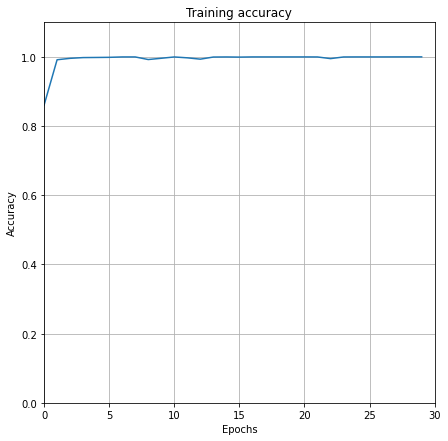

In [ ]:
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.xlim(0,30)
plt.grid()
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training accuracy')
plt.show()

#Testing Fast 3D CNN

##Resizing X_test to feed it as input to CNN

In [ ]:
X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
X_test.shape

(10047, 11, 11, 20, 1)

##Applying one-hot encoding to y_test

In [ ]:
y_test = np_utils.to_categorical(y_test)
print(f"y_test shape after applying one hot encoding : {y_test.shape}")

y_test shape after applying one hot encoding : (10047, 9)


##Predicting Testing Data

In [ ]:
start = time.time()

Y_pred_test = model.predict(X_test)

end = time.time()
testing_time = end - start
print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


y_pred_test = np.argmax(Y_pred_test, axis=1)
y_test = np.argmax(y_test, axis=1)

Time taken for predicting test set : 0:00:11.670265





##Creating Confusion Matrix

In [ ]:
def cnn_report(y_test,y_pred_test):
  
  class_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees',
                 'Painted metal sheets', 'Bare Soil', 'Bitumen', 
                 'Self-Blocking Bricks', 'Shadows']

  
  y_unique=np.unique(y_pred_test)
  y_pred_test_unique=list(y_unique)
  #print(y_pred_test_unique)
  #print(np.unique(y_test))
  print(f"Number of classes predicted : {len(y_pred_test_unique)}\n")
  
  req_class_names=[]
  for i in y_unique:
    req_class_names.append(class_names[i])  
  
  print("Confusion matrix : \n")
  confusion = confusion_matrix(y_test, y_pred_test)
  annot = np.empty_like(confusion).astype(str)
  cm_sum = np.sum(confusion, axis=1, keepdims=True)
  accuracy_class = confusion / confusion.sum(axis=1) * 100
  rows, cols = confusion.shape
  for i in range(rows):
    for j in range(cols):
      c = confusion[i, j]
      p = accuracy_class[i, j]
      if i == j:
          s = cm_sum[i]
          annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
      elif c == 0:
          annot[i, j] = ''
      else:
          annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(confusion, index=req_class_names, columns=req_class_names)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.show()
  fig, ax = plt.subplots(figsize=(25,15))
  sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)
  plt.show()
  
  classification = classification_report(y_pred_test, y_test, target_names=req_class_names)
  print("\nClassification report : \n")
  print(classification)
  

  accuracy = accuracy_score(y_pred_test, y_test)
  print(f"\nTesting set accuracy : {accuracy*100} %")
  
  kappa = cohen_kappa_score(y_pred_test, y_test)
  print(f"\nCohen kappa score : {kappa}\n\n\n") 

Number of classes predicted : 9

Confusion matrix : 



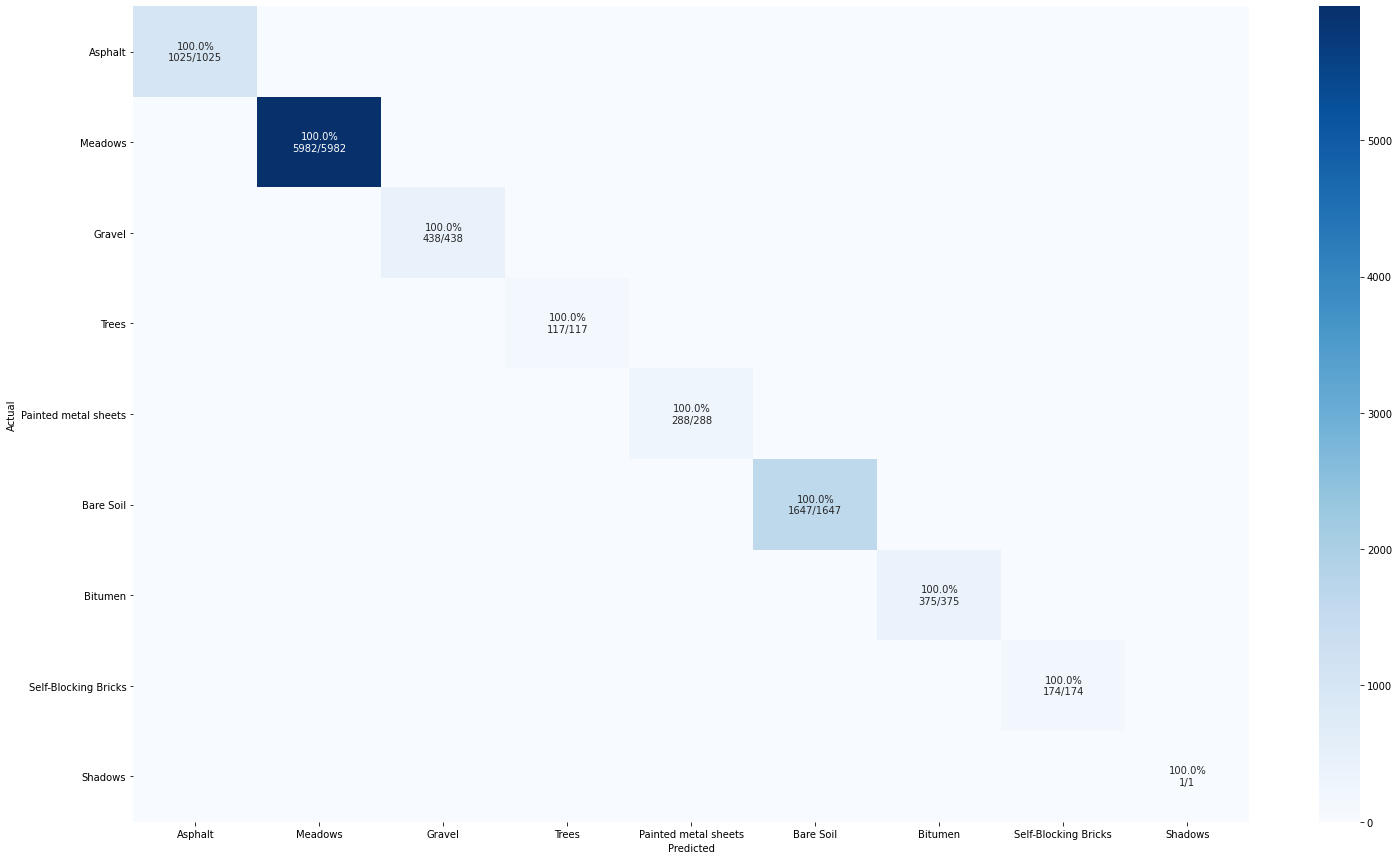


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      1025
             Meadows       1.00      1.00      1.00      5982
              Gravel       1.00      1.00      1.00       438
               Trees       1.00      1.00      1.00       117
Painted metal sheets       1.00      1.00      1.00       288
           Bare Soil       1.00      1.00      1.00      1647
             Bitumen       1.00      1.00      1.00       375
Self-Blocking Bricks       1.00      1.00      1.00       174
             Shadows       1.00      1.00      1.00         1

            accuracy                           1.00     10047
           macro avg       1.00      1.00      1.00     10047
        weighted avg       1.00      1.00      1.00     10047


Testing set accuracy : 100.0 %

Cohen kappa score : 1.0





In [ ]:
cnn_report(y_test,y_pred_test)

##Predicting Entire Dataset 

In [ ]:
# Load the original dataset
X, y = load_dataset()

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)





In [ ]:
X,pca = apply_pca(X, number_of_components)

Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)





In [ ]:
X = zero_padding_X(X, window_size//2)

The shape of X after zero padding : (620, 350, 20)


In [ ]:
height = y.shape[0]
width = y.shape[1]

In [ ]:
def Patch(data,height_index,width_index,window_size):
    
    height_slice = slice(height_index, height_index+window_size)
    width_slice = slice(width_index, width_index+window_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# calculate the predicted image
from tqdm.auto import trange

predicted_output = np.zeros((height,width))

start = time.time()

for i in trange(height, desc="Predicting image"):
    #for j in trange(width,leave=False):
    for j in range(width):
      target = int(y[i,j])
      if target == 0 :
          continue
      else :
          image_patch=Patch(X,i,j,window_size=window_size)
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          prediction = (model.predict(X_test_image))
          prediction = np.argmax(prediction, axis=1)
          predicted_output[i][j] = prediction+1

end = time.time()
testing_time = end - start
print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")
  


Time taken for predicting entire image : 0:26:10.400771





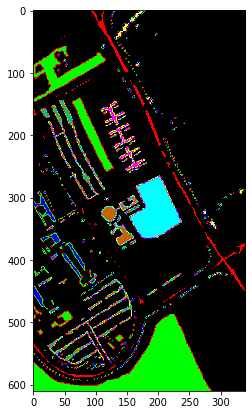

In [ ]:
# Display groundtruth image
ground_truth=spectral.imshow(classes=y,figsize=(7,7))

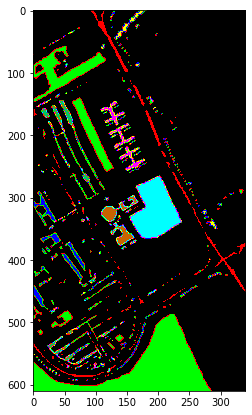

In [ ]:
# Display predicted image
predict_image = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,7))

#Combining Code into single cell

In [ ]:
def hybridSN_comp(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 20, size =  128):

  ## Importing dataset
  X,y= load_dataset()

  
  ## Applying dimensionality reduction -  Passing number of components 20 for PCA to the function apply_pca
  X,pca = apply_pca(X,number_of_components)
  
  # Creating smaller image cuboids with a give window size
  X,y = create_image_cuboids(X,y,window_size, labelling_type=labelling_type)

  # Count the number of elements present in each class of y
  count_frequency(y,name="y")

  
  ## Splitting dataset into training and testing dataset with given test ratio
  X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)

  # Count the number of elements present in each class of y_train and y_test
  count_frequency(y_train, name="y_train")
  count_frequency(y_test, name="y_test")
  
  
  ## Training CNN

  print("\n\n\nTrain CNN\n")

  # Reshaping X_train to feed it as input to CNN
  X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)

  # Apply one-hot encoding to y_train
  y_train = np_utils.to_categorical(y_train)
  print(f"y_train shape after applying one hot encoding : {y_train.shape}\n\n")

  S = window_size
  L = number_of_components
  output_units = 9
  
  # Input layer
  input_layer = Input((S, S, L, 1))

  # 3D Convolutional Layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  conv3d_shape = conv_layer3.shape
  conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
  conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
  # Faltten 3D Convolutional Layer
  flatten_layer = Flatten()(conv_layer4)
  # Fully Connected Layers
  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(dropout)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(dropout)(dense_layer2)
  output_layer = Dense(units=9, activation='softmax')(dense_layer2)

  # Define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # Provides the architecture details of CNN model
  model.summary()

  # Compiling the model
  adam = Adam(lr=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # Checkpoint
  filepath = "best-model.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  start = time.time()
  
  # Train CNN with given number of epochs, batch size and training data set
  history = model.fit(x=X_train, y=y_train, batch_size=size, epochs=epoch, callbacks=callbacks_list)

  end = time.time()
  training_time = end - start
  print(f"\nTime taken for training CNN : {str(timedelta(seconds=training_time))}\n\n\n")

  plt.figure(figsize=(7,7))
  plt.ylim(0,1.1)
  plt.xlim(0,epoch)
  plt.grid()
  plt.plot(history.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.title('Training accuracy')
  plt.show()
  
  
  ## Testing CNN model

  print(f"Test CNN \n")
 
  # Reshaping X_test to feed it as input to CNN 
  X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
  
  # Applying one-hot encoding to y_test 
  y_test = np_utils.to_categorical(y_test)
  print(f"y_test shape after applying one hot encoding : {y_test.shape}\n")
  
  start = time.time()
  
  # Predicting the testing dataset
  Y_pred_test = model.predict(X_test)
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


  ## Create classification report and confusion matrix
  
  print("CNN report\n")

  # Returns the indices of the maximmum values along an axis
  y_pred_test = np.argmax(Y_pred_test, axis=1)
  
  # Compare y_pred_test and y_test and print classification report
  classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
  print(classification)
  
  # Compare y_pred_test and y_test and print confusion matrix
  confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
  print(confusion)
  print(f"The shape of confusion matrix is : {confusion.shape}\n\n\n")
  #np.sum(confusion)

  
  ## Predicting entire dataset

  print("Predicting entire image\n")
  
  # load the original image
  X, y = load_dataset()

  height = y.shape[0]
  width = y.shape[1]

  # Applying PCA with given number of components
  X,pca = apply_pca(X, number_of_components)
  
  # Applying zero padding
  X = zero_padding_X(X, window_size//2)

  # Create a numpy array of zeros with dimensions height and width
  outputs = np.zeros((height,width))

  # Import library to display progress bar
  from tqdm.auto import trange  
  
  start = time.time()
  print("\n")
  
  for i in trange(height, desc="Predicting image"):
    for j in range(width):
      
      # Extracting labels from dataset
      target = int(y[i,j])
      
      # Predicting only for classes that are not zero
      if target == 0 :
          continue
      else :
          # Creating smaller cuboids of images 
          image_patch=Patch(X,i,j,window_size)
          
          # Resize image_patch to feed it as input to CNN model
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          
          # Predict the class X_test_image belongs to
          prediction = (model.predict(X_test_image))
          
          prediction = np.argmax(prediction, axis=1)
          outputs[i][j] = prediction+1
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")
  
  

  # Display groundtruth image
  ground_truth = spectral.imshow(classes = y,figsize =(7,7))
  
  

  # Display predicted image
  predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

#Majority Labelling vs Center Labelling

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (618, 348, 20)
The shape of y after zero padding : (618, 348)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (32724, 9, 9, 20)
The shape of y_cuboids_labels : (32724,)



Number of elements present in each class of y: {0.0: 4025, 1.0: 18358, 2.0: 1573, 3.0: 512, 4.0: 1169, 5.0: 4997, 6.0: 1192, 7.0: 837, 8.0: 61}



Splitting Dataset

X_train shape : (21925, 9, 9, 20)
y_train shape : (21925,)
X_test shape  : (10799, 9, 9, 20)
y_test shape  : (10799,)
Number of elements present in each class of y_train: {0.0: 2697, 1.0: 12300, 2.0: 1054, 3.0: 343, 4.0: 783, 5.0: 3348, 6.0: 798, 7.0: 561, 8.0: 41}
Number of e

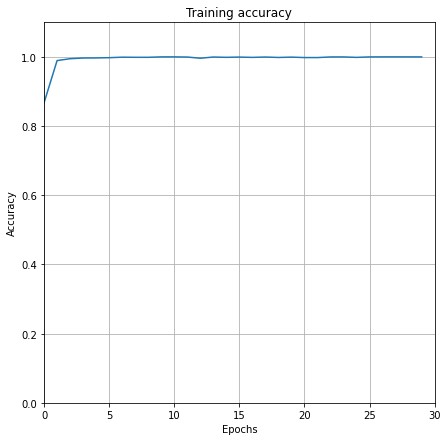

Test CNN 

y_test shape after applying one hot encoding : (10799, 9)

Time taken for predicting test set : 0:00:07.126676



CNN report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1328
           1       1.00      1.00      1.00      6058
           2       1.00      1.00      1.00       519
           3       1.00      0.99      1.00       169
           4       1.00      1.00      1.00       386
           5       1.00      1.00      1.00      1649
           6       1.00      1.00      1.00       394
           7       1.00      1.00      1.00       276
           8       1.00      1.00      1.00        20

    accuracy                           1.00     10799
   macro avg       1.00      1.00      1.00     10799
weighted avg       1.00      1.00      1.00     10799

[[1328    0    0    0    0    0    0    0    0]
 [   0 6058    0    0    0    0    0    0    0]
 [   0    0  519    0    0    0    0    0    0]
 [   0    1   


Time taken for predicting entire image : 0:28:31.406965





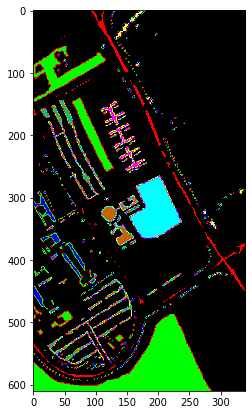

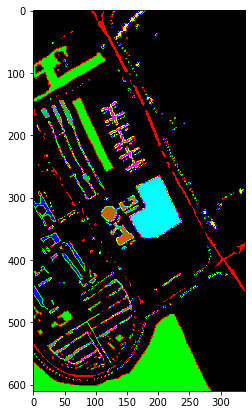

In [ ]:
hybridSN_comp(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (618, 348, 20)
The shape of y after zero padding : (618, 348)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 9, 9, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 9, 9, 20)
y_train shape : (28659,)
X_test shape  : (14117, 9, 9, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}
Numbe

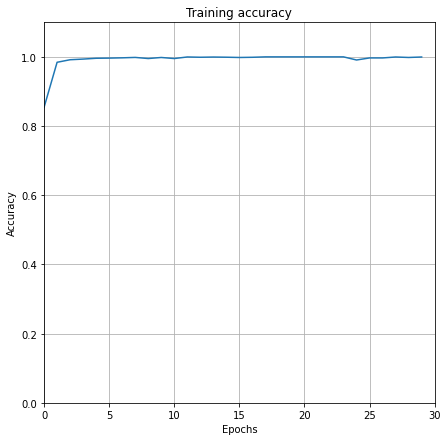

Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:00:09.434641



CNN report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2188
           1       1.00      1.00      1.00      6155
           2       1.00      1.00      1.00       693
           3       1.00      1.00      1.00      1011
           4       1.00      1.00      1.00       444
           5       1.00      1.00      1.00      1660
           6       1.00      1.00      1.00       439
           7       1.00      1.00      1.00      1215
           8       1.00      1.00      1.00       312

    accuracy                           1.00     14117
   macro avg       1.00      1.00      1.00     14117
weighted avg       1.00      1.00      1.00     14117

[[2187    0    0    0    0    0    0    1    0]
 [   0 6154    0    0    0    0    0    1    0]
 [   0    0  692    0    0    0    0    1    0]
 [   0    1   


Time taken for predicting entire image : 0:26:01.163033





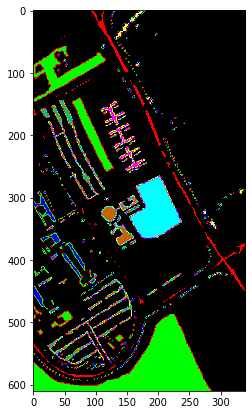

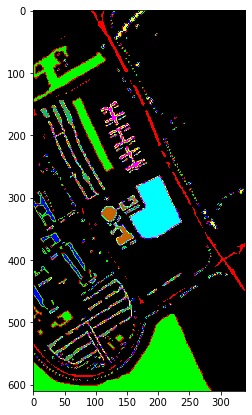

In [ ]:
hybridSN_comp(number_of_components = 20, window_size = 9, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

#Comparision of Different Window sizes

In [ ]:
def hybridSN(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128):

  ## Importing dataset
  X,y= load_dataset()

  
  ## Applying dimensionality reduction -  Passing number of components 20 for PCA to the function apply_pca
  X,pca = apply_pca(X,number_of_components)
  
  # Creating smaller image cuboids with a give window size
  X,y = create_image_cuboids(X,y,window_size, labelling_type=labelling_type)

  # Count the number of elements present in each class of y
  count_frequency(y,name="y")

  
  ## Splitting dataset into training and testing dataset with given test ratio
  X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)

  # Count the number of elements present in each class of y_train and y_test
  count_frequency(y_train, name="y_train")
  count_frequency(y_test, name="y_test")
  
  
  ## Training CNN

  print("\n\n\nTrain CNN\n")

  # Reshaping X_train to feed it as input to CNN
  X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)

  # Apply one-hot encoding to y_train
  y_train = np_utils.to_categorical(y_train)
  print(f"y_train shape after applying one hot encoding : {y_train.shape}\n\n")

  S = window_size
  L = number_of_components
  output_units = 9
  
  # Input layer
  input_layer = Input((S, S, L, 1))

  # 3D Convolutional Layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  conv3d_shape = conv_layer3.shape
  conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
  conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
  # Faltten 3D Convolutional Layer
  flatten_layer = Flatten()(conv_layer4)
  # Fully Connected Layers
  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(dropout)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(dropout)(dense_layer2)
  output_layer = Dense(units=9, activation='softmax')(dense_layer2)

  # Define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # Provides the architecture details of CNN model
  model.summary()

  # Compiling the model
  adam = Adam(lr=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # Checkpoint
  filepath = "best-model.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  start = time.time()
  
  # Train CNN with given number of epochs, batch size and training data set
  history = model.fit(x=X_train, y=y_train, batch_size=size, epochs=epoch, callbacks=callbacks_list)

  end = time.time()
  training_time = end - start
  print(f"\nTime taken for training CNN : {str(timedelta(seconds=training_time))}\n")

  plt.figure(figsize=(7,7))
  plt.ylim(0,1.1)
  plt.xlim(0,epoch)
  plt.grid()
  plt.plot(history.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.title('Training accuracy')
  plt.show()



  ## Testing CNN model

  print(f"\n\n\nTest CNN \n")
 
  # Reshaping X_test to feed it as input to CNN 
  X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
  
  # Applying one-hot encoding to y_test 
  y_test = np_utils.to_categorical(y_test)
  print(f"y_test shape after applying one hot encoding : {y_test.shape}\n")
  
  start = time.time()
  
  # Predicting the testing dataset
  Y_pred_test = model.predict(X_test)
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


  ## Create classification report and confusion matrix
  
  print("Testing set CNN report\n")

  # Returns the indices of the maximmum values along an axis
  y_pred_test = np.argmax(Y_pred_test, axis=1)
  y_test = np.argmax(y_test, axis=1)
  
  
  cnn_report(y_test,y_pred_test)
  

  
  ## Predicting entire dataset

  print("Predicting entire image\n")
  
  # load the original image
  X, y = load_dataset()

  height = y.shape[0]
  width = y.shape[1]

  # Applying PCA with given number of components
  X,pca = apply_pca(X, number_of_components)
  
  # Applying zero padding
  X = zero_padding_X(X, window_size//2)

  # Create a numpy array of zeros with dimensions height and width
  predicted_output = np.zeros((height,width))

  # Import library to display progress bar
  from tqdm.auto import trange  
  
  start = time.time()
  print("\n")
  
  for i in trange(height, desc="Predicting image"):
    for j in range(width):
      
      # Extracting labels from dataset
      target = int(y[i,j])
      
      # Predicting only for classes that are not zero
      if target == 0 :
          continue
      else :
          # Creating smaller cuboids of images 
          image_patch=Patch(X,i,j,window_size)
          
          # Resize image_patch to feed it as input to CNN model
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          
          # Predict the class X_test_image belongs to
          prediction = (model.predict(X_test_image))
          
          prediction = np.argmax(prediction, axis=1)
          predicted_output[i][j] = prediction+1
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")
  
 
  # Display groundtruth image
  ground_truth = spectral.imshow(classes = y,figsize =(7,7))
  plt.show()
  
  
  
  # Display predicted image
  predict_image = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,7))
  plt.show()
  
  
  print("\n\n\nCNN report for predicting entire dataset\n")
  
  y_actual=np.ravel(y).astype(int)
  y_predicted = np.ravel(predicted_output).astype(int)
  y_predicted=y_predicted[y_predicted>0]
  y_actual=y_actual[y_actual>0]
  y_predicted-=1
  y_actual-=1
  #print(y_actual.shape)
  #print(y_predicted.shape)
  #print(np.unique(y_actual))
  #print(np.unique(y_predicted))

  cnn_report(y_actual,y_predicted)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (618, 348, 20)
The shape of y after zero padding : (618, 348)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 9, 9, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 9, 9, 20)
y_train shape : (28659,)
X_test shape  : (14117, 9, 9, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}
Numbe

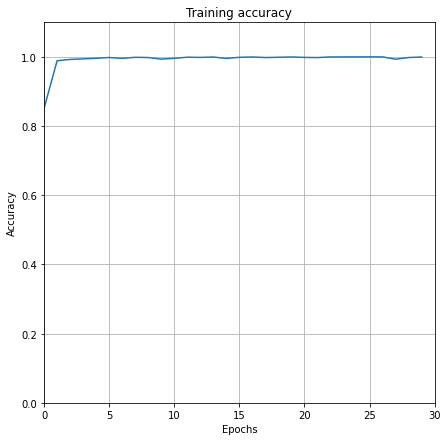




Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:00:09.680666



Testing set CNN report

Number of classes predicted : 9

Confusion matrix : 



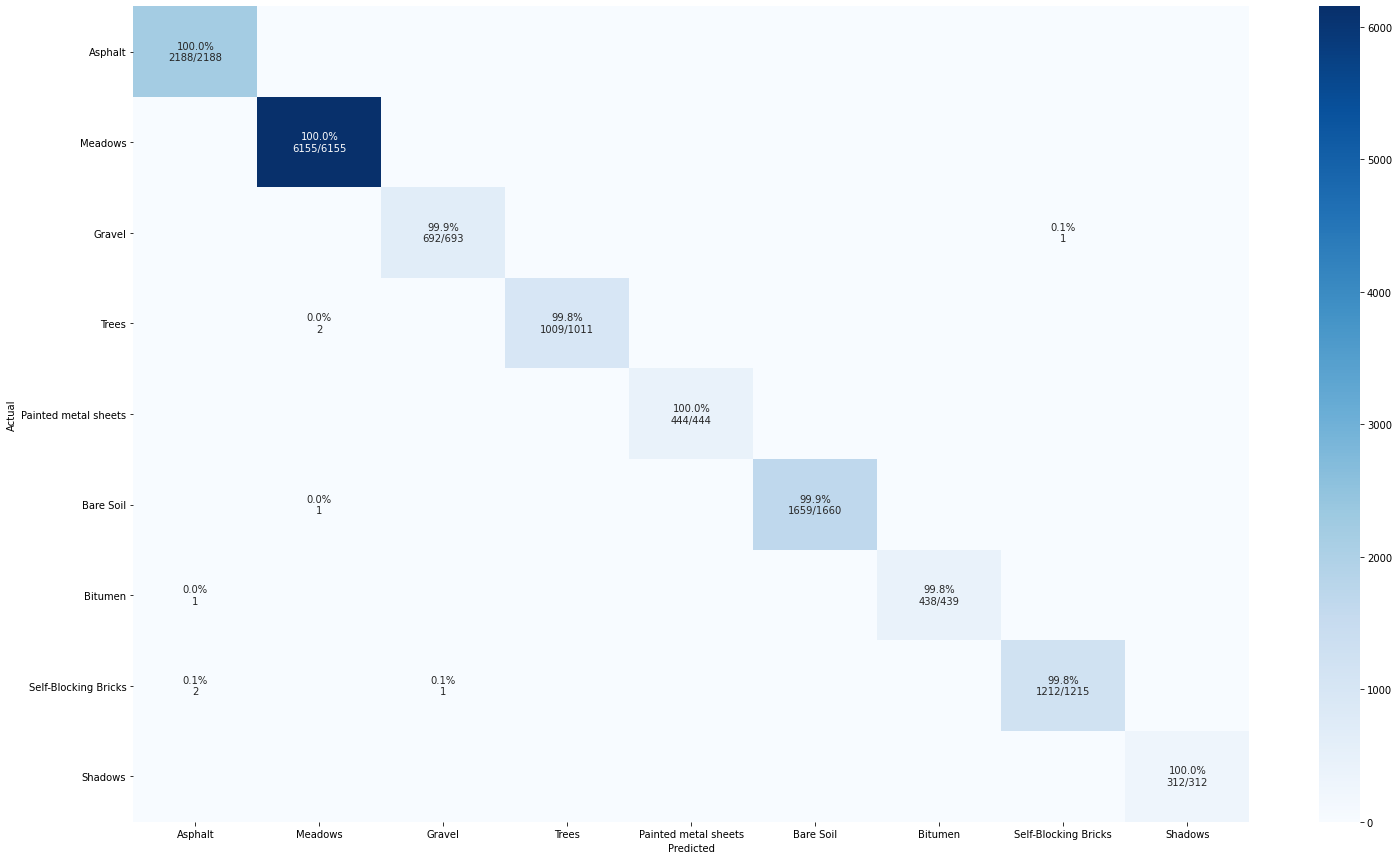


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      2191
             Meadows       1.00      1.00      1.00      6158
              Gravel       1.00      1.00      1.00       693
               Trees       1.00      1.00      1.00      1009
Painted metal sheets       1.00      1.00      1.00       444
           Bare Soil       1.00      1.00      1.00      1659
             Bitumen       1.00      1.00      1.00       438
Self-Blocking Bricks       1.00      1.00      1.00      1213
             Shadows       1.00      1.00      1.00       312

            accuracy                           1.00     14117
           macro avg       1.00      1.00      1.00     14117
        weighted avg       1.00      1.00      1.00     14117


Testing set accuracy : 99.94333073599206 %

Cohen kappa score : 0.9992489881162889



Predicting entire image

Load dataset

X shape : (610, 340, 103)
y shape : (6


Time taken for predicting entire image : 0:29:28.695581





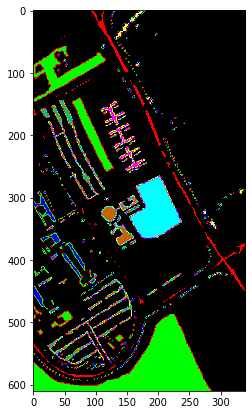

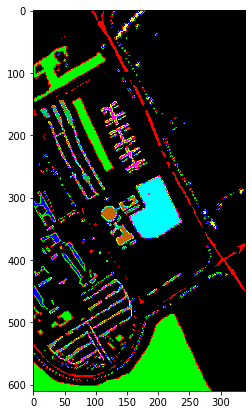




CNN report for predicting entire dataset

Number of classes predicted : 9

Confusion matrix : 



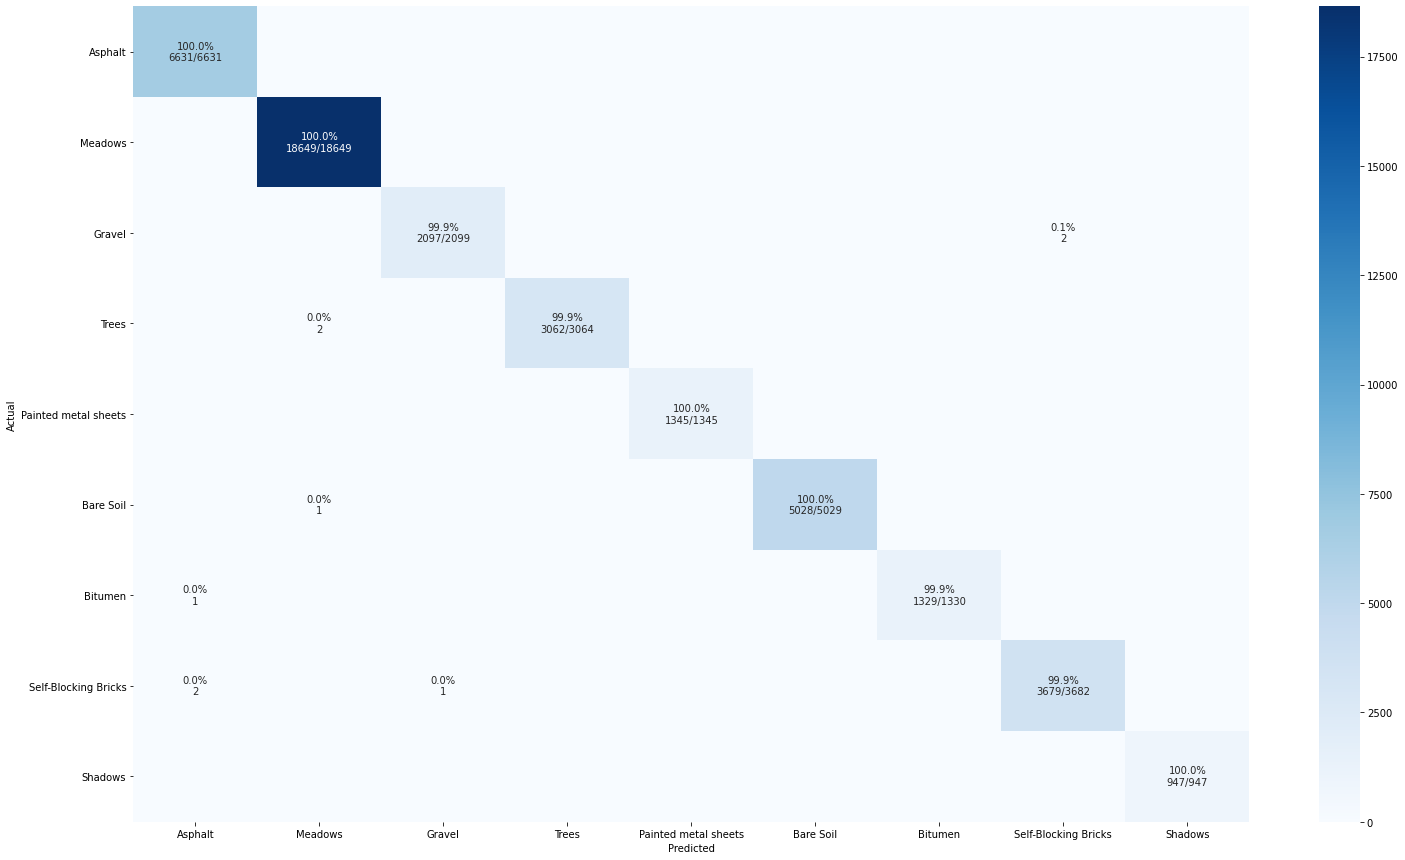


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      6634
             Meadows       1.00      1.00      1.00     18652
              Gravel       1.00      1.00      1.00      2098
               Trees       1.00      1.00      1.00      3062
Painted metal sheets       1.00      1.00      1.00      1345
           Bare Soil       1.00      1.00      1.00      5028
             Bitumen       1.00      1.00      1.00      1329
Self-Blocking Bricks       1.00      1.00      1.00      3681
             Shadows       1.00      1.00      1.00       947

            accuracy                           1.00     42776
           macro avg       1.00      1.00      1.00     42776
        weighted avg       1.00      1.00      1.00     42776


Testing set accuracy : 99.97896016457827 %

Cohen kappa score : 0.9997211991548035





In [ ]:
hybridSN(number_of_components = 20, window_size = 9, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (620, 350, 20)
The shape of y after zero padding : (620, 350)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 11, 11, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 11, 11, 20)
y_train shape : (28659,)
X_test shape  : (14117, 11, 11, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}

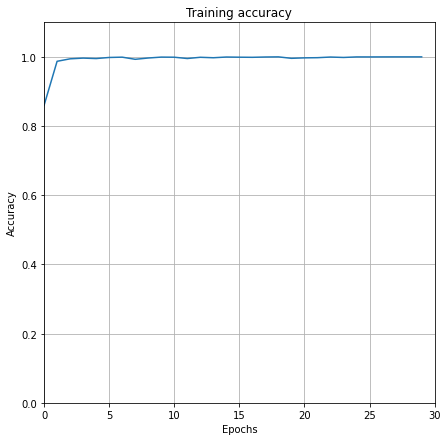




Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:00:16.727621



Testing set CNN report

Number of classes predicted : 9

Confusion matrix : 



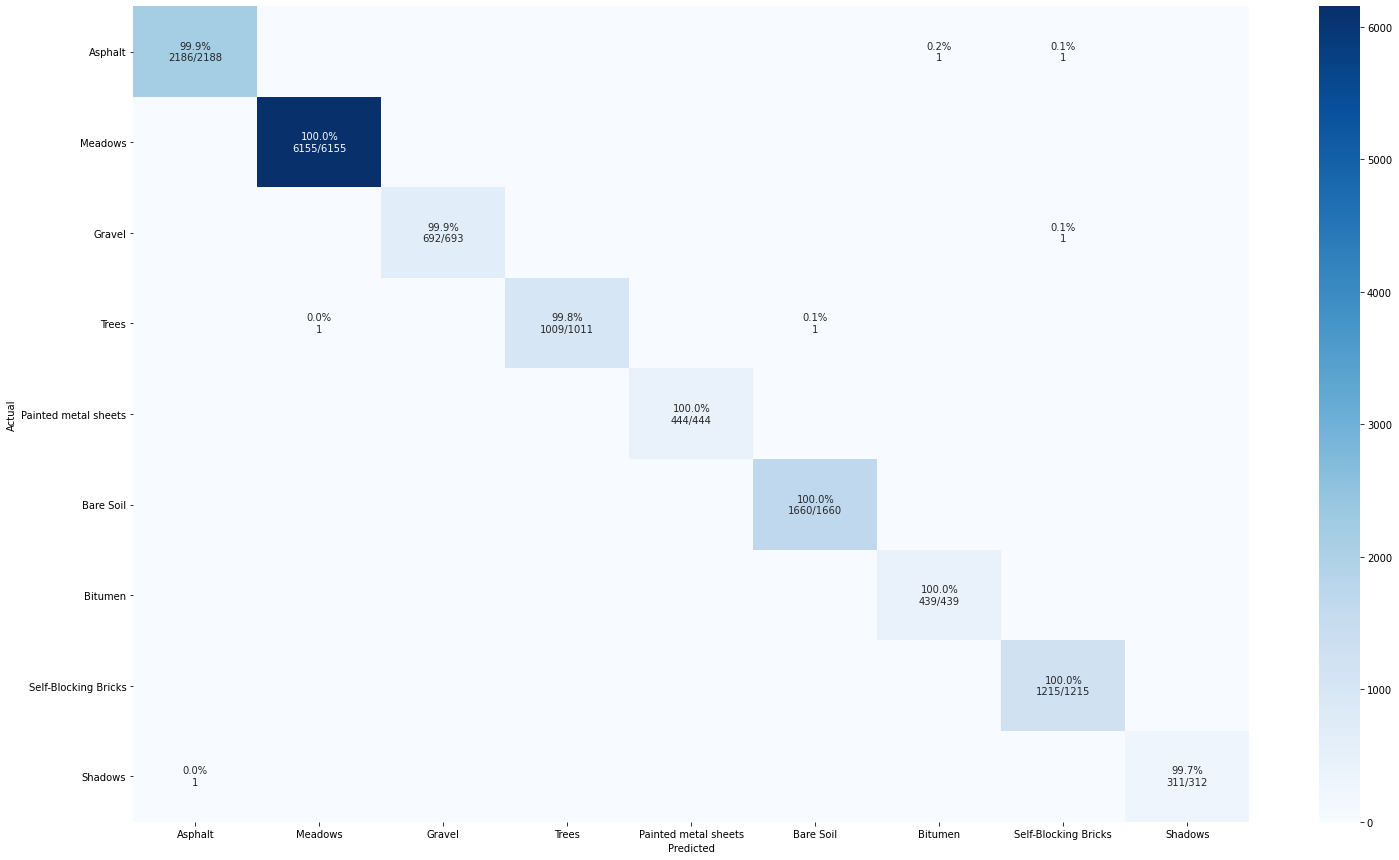


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      2187
             Meadows       1.00      1.00      1.00      6156
              Gravel       1.00      1.00      1.00       692
               Trees       1.00      1.00      1.00      1009
Painted metal sheets       1.00      1.00      1.00       444
           Bare Soil       1.00      1.00      1.00      1661
             Bitumen       1.00      1.00      1.00       440
Self-Blocking Bricks       1.00      1.00      1.00      1217
             Shadows       1.00      1.00      1.00       311

            accuracy                           1.00     14117
           macro avg       1.00      1.00      1.00     14117
        weighted avg       1.00      1.00      1.00     14117


Testing set accuracy : 99.95749805199405 %

Cohen kappa score : 0.9994367898096338



Predicting entire image

Load dataset

X shape : (610, 340, 103)
y shape : (6


Time taken for predicting entire image : 0:28:05.911627





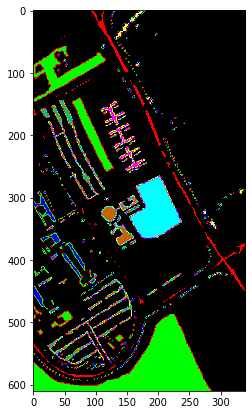

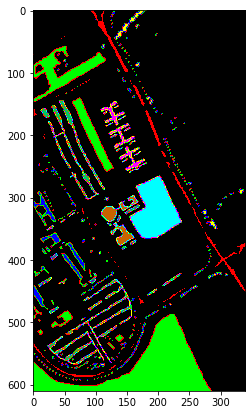




CNN report for predicting entire dataset

Number of classes predicted : 9

Confusion matrix : 



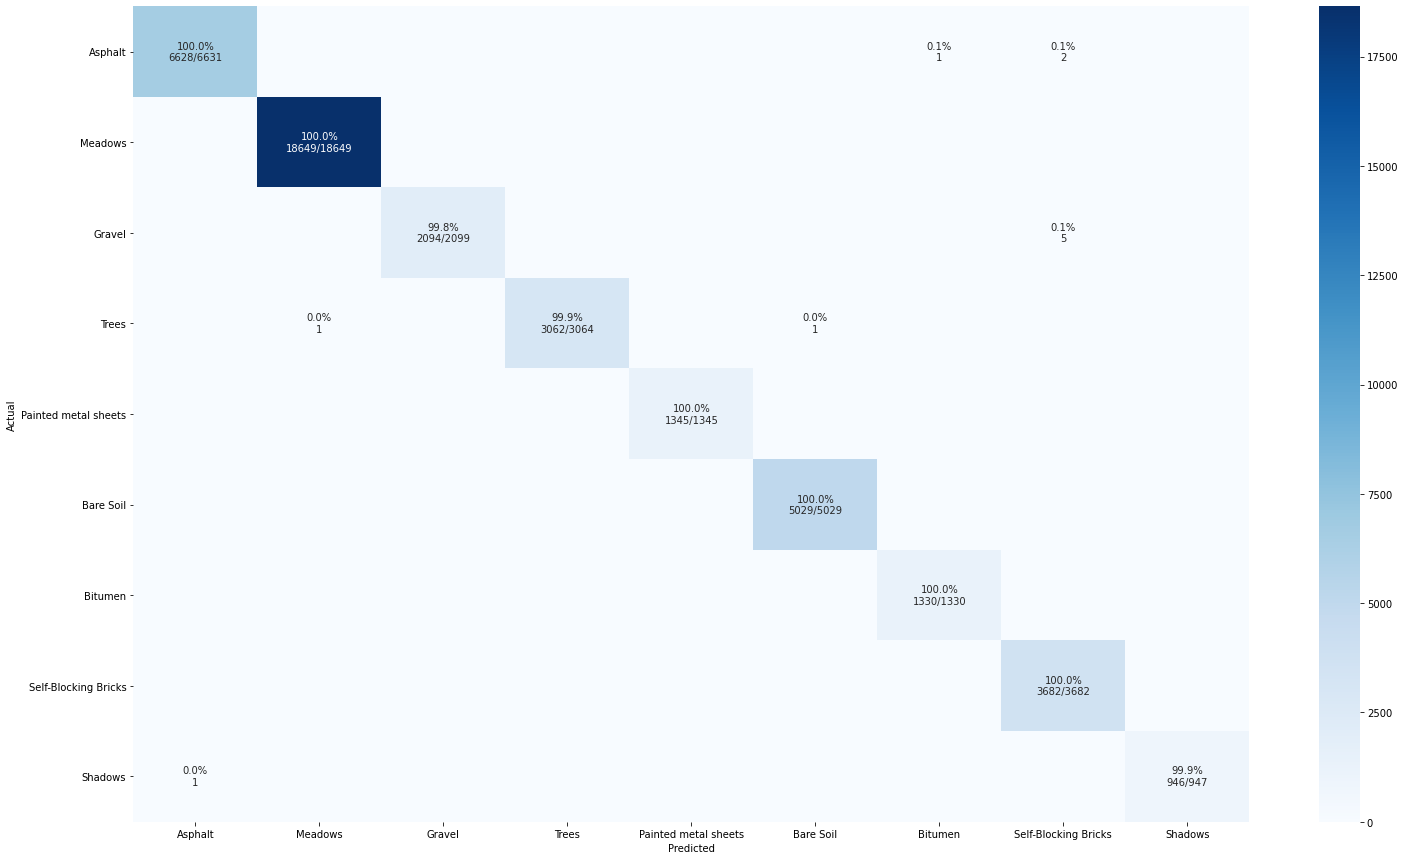


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      6629
             Meadows       1.00      1.00      1.00     18650
              Gravel       1.00      1.00      1.00      2094
               Trees       1.00      1.00      1.00      3062
Painted metal sheets       1.00      1.00      1.00      1345
           Bare Soil       1.00      1.00      1.00      5030
             Bitumen       1.00      1.00      1.00      1331
Self-Blocking Bricks       1.00      1.00      1.00      3689
             Shadows       1.00      1.00      1.00       946

            accuracy                           1.00     42776
           macro avg       1.00      1.00      1.00     42776
        weighted avg       1.00      1.00      1.00     42776


Testing set accuracy : 99.97428464559566 %

Cohen kappa score : 0.9996592526952252





In [ ]:
hybridSN(number_of_components = 20, window_size = 11, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (622, 352, 20)
The shape of y after zero padding : (622, 352)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 13, 13, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 13, 13, 20)
y_train shape : (28659,)
X_test shape  : (14117, 13, 13, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}

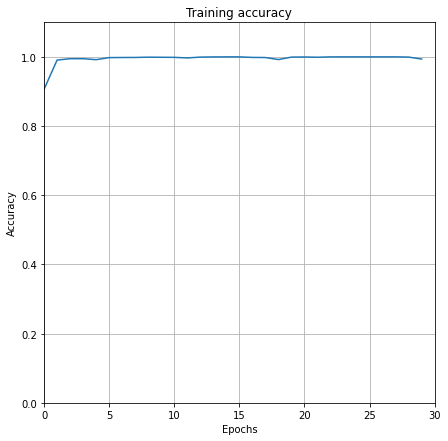




Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:00:27.005562



Testing set CNN report

Number of classes predicted : 9

Confusion matrix : 



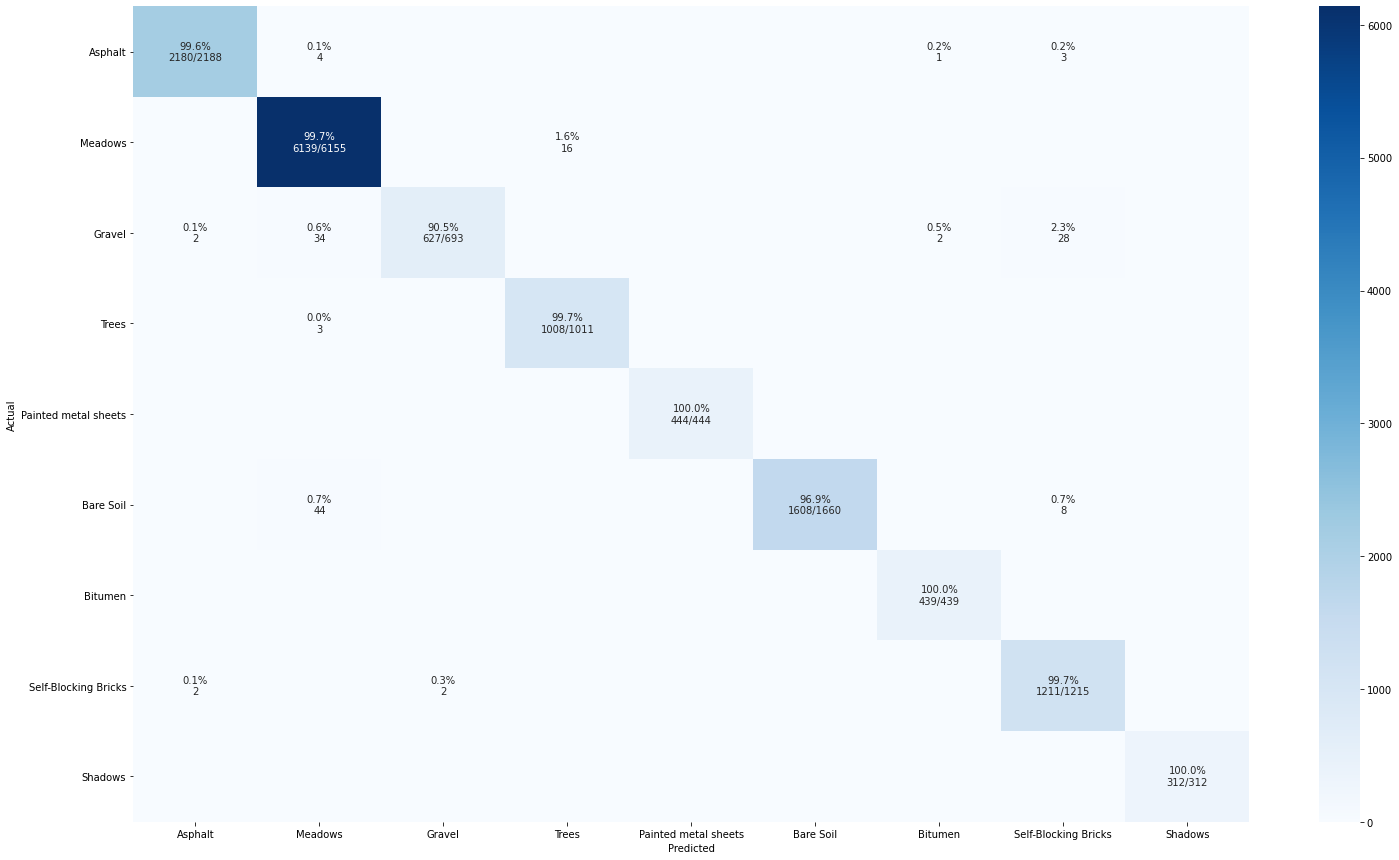


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      2184
             Meadows       1.00      0.99      0.99      6224
              Gravel       0.90      1.00      0.95       629
               Trees       1.00      0.98      0.99      1024
Painted metal sheets       1.00      1.00      1.00       444
           Bare Soil       0.97      1.00      0.98      1608
             Bitumen       1.00      0.99      1.00       442
Self-Blocking Bricks       1.00      0.97      0.98      1250
             Shadows       1.00      1.00      1.00       312

            accuracy                           0.99     14117
           macro avg       0.98      0.99      0.99     14117
        weighted avg       0.99      0.99      0.99     14117


Testing set accuracy : 98.94453495785224 %

Cohen kappa score : 0.9859822221591933



Predicting entire image

Load dataset

X shape : (610, 340, 103)
y shape : (6


Time taken for predicting entire image : 0:28:49.561649





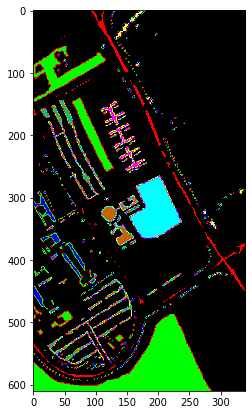

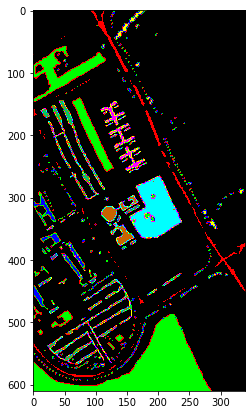




CNN report for predicting entire dataset

Number of classes predicted : 9

Confusion matrix : 



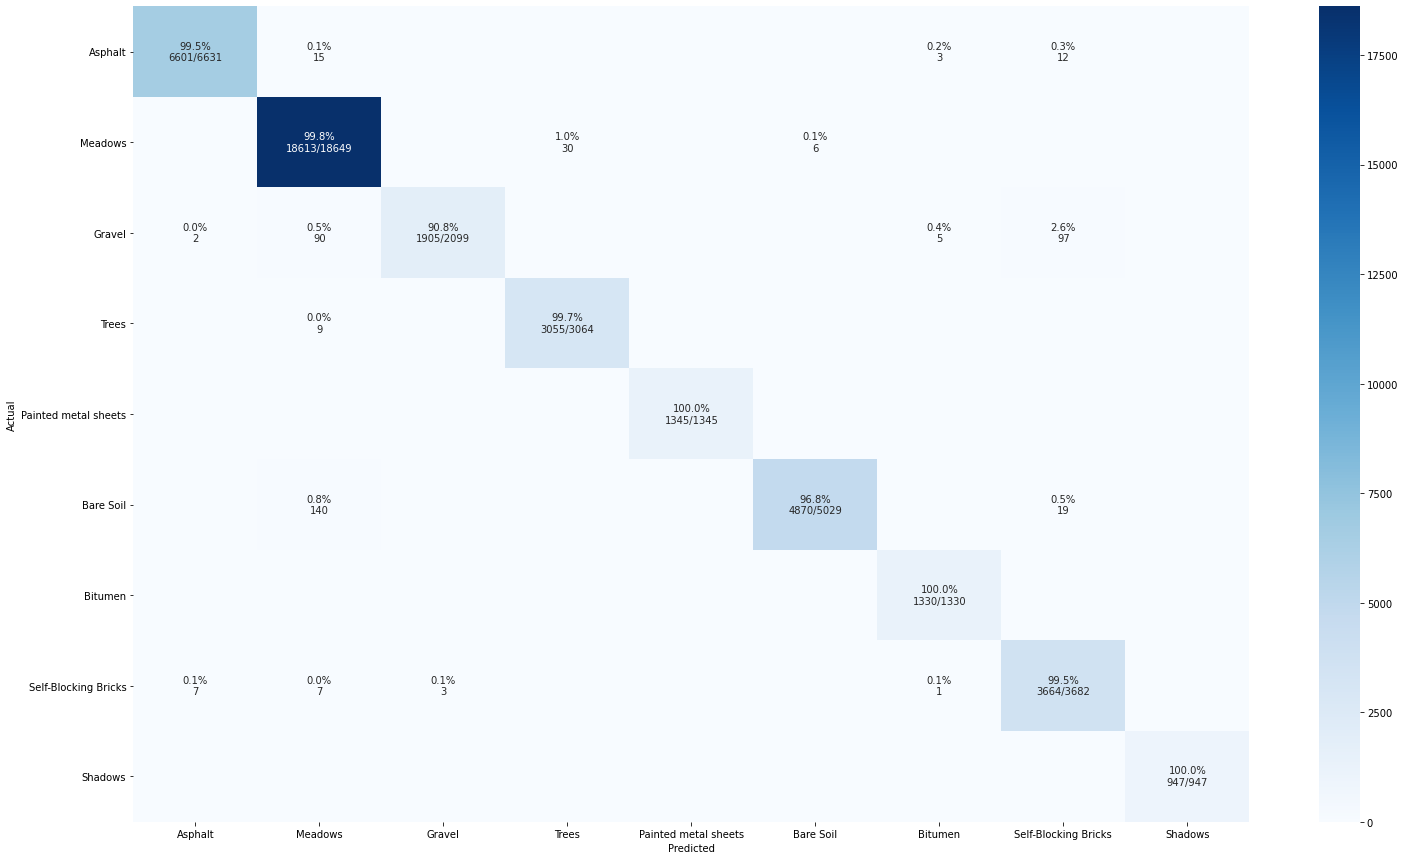


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      6610
             Meadows       1.00      0.99      0.99     18874
              Gravel       0.91      1.00      0.95      1908
               Trees       1.00      0.99      0.99      3085
Painted metal sheets       1.00      1.00      1.00      1345
           Bare Soil       0.97      1.00      0.98      4876
             Bitumen       1.00      0.99      1.00      1339
Self-Blocking Bricks       1.00      0.97      0.98      3792
             Shadows       1.00      1.00      1.00       947

            accuracy                           0.99     42776
           macro avg       0.98      0.99      0.99     42776
        weighted avg       0.99      0.99      0.99     42776


Testing set accuracy : 98.95735926687863 %

Cohen kappa score : 0.9861506696076172





In [ ]:
hybridSN(number_of_components = 20, window_size = 13, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (624, 354, 20)
The shape of y after zero padding : (624, 354)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 15, 15, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 15, 15, 20)
y_train shape : (28659,)
X_test shape  : (14117, 15, 15, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}

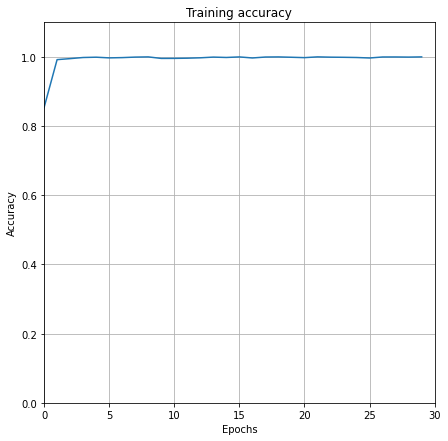




Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:00:38.329504



Testing set CNN report

Number of classes predicted : 9

Confusion matrix : 



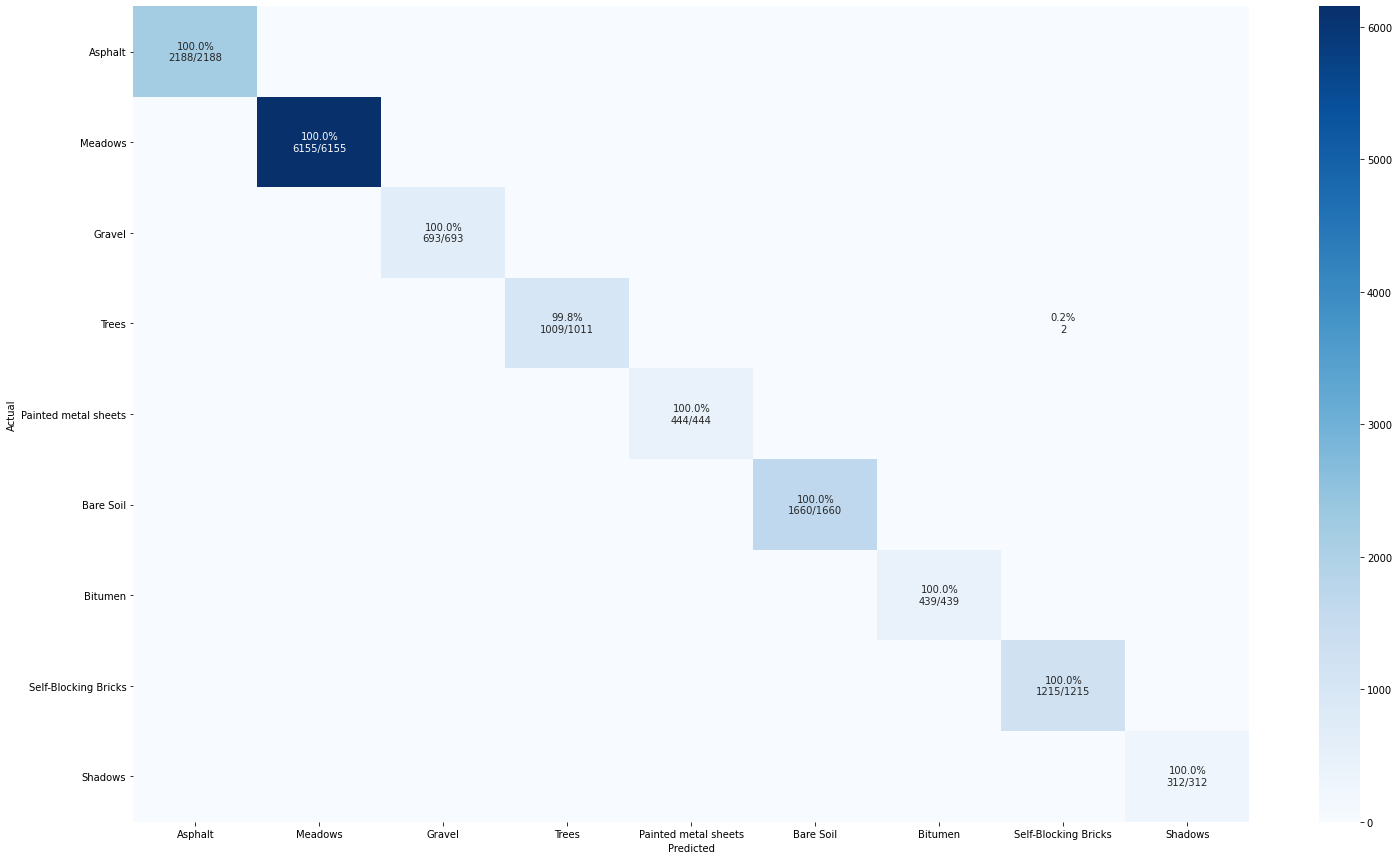


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      2188
             Meadows       1.00      1.00      1.00      6155
              Gravel       1.00      1.00      1.00       693
               Trees       1.00      1.00      1.00      1009
Painted metal sheets       1.00      1.00      1.00       444
           Bare Soil       1.00      1.00      1.00      1660
             Bitumen       1.00      1.00      1.00       439
Self-Blocking Bricks       1.00      1.00      1.00      1217
             Shadows       1.00      1.00      1.00       312

            accuracy                           1.00     14117
           macro avg       1.00      1.00      1.00     14117
        weighted avg       1.00      1.00      1.00     14117


Testing set accuracy : 99.98583268399803 %

Cohen kappa score : 0.9998122695874152



Predicting entire image

Load dataset

X shape : (610, 340, 103)
y shape : (6


Time taken for predicting entire image : 0:35:33.418551





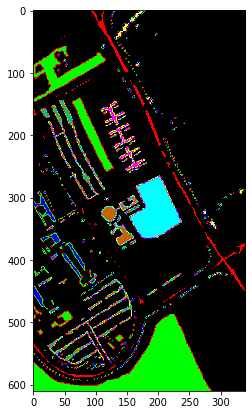

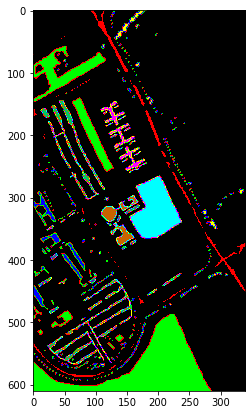




CNN report for predicting entire dataset

Number of classes predicted : 9

Confusion matrix : 



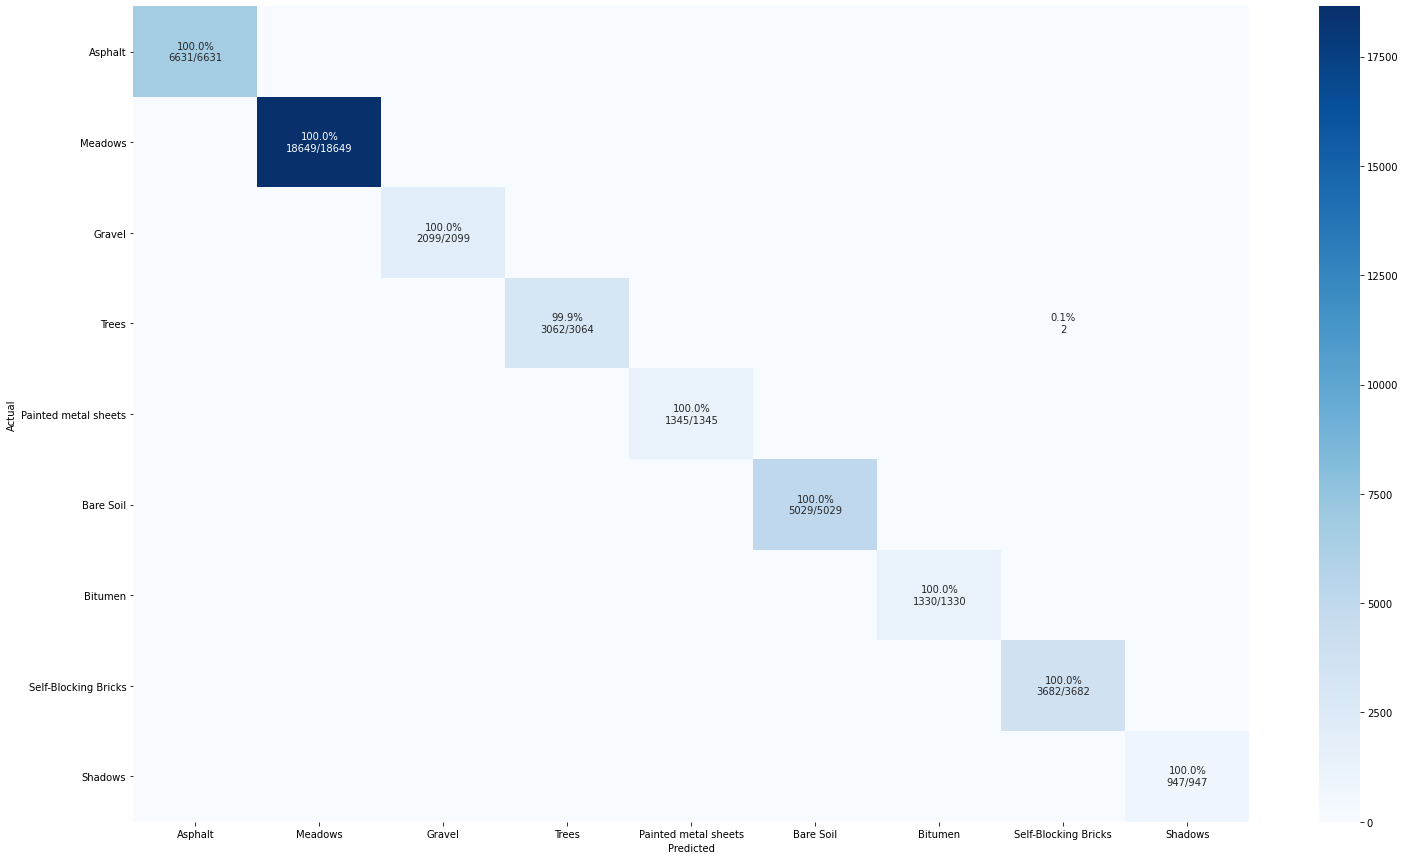


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      6631
             Meadows       1.00      1.00      1.00     18649
              Gravel       1.00      1.00      1.00      2099
               Trees       1.00      1.00      1.00      3062
Painted metal sheets       1.00      1.00      1.00      1345
           Bare Soil       1.00      1.00      1.00      5029
             Bitumen       1.00      1.00      1.00      1330
Self-Blocking Bricks       1.00      1.00      1.00      3684
             Shadows       1.00      1.00      1.00       947

            accuracy                           1.00     42776
           macro avg       1.00      1.00      1.00     42776
        weighted avg       1.00      1.00      1.00     42776


Testing set accuracy : 99.99532448101739 %

Cohen kappa score : 0.9999380467841819





In [ ]:
hybridSN(number_of_components = 20, window_size = 15, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)



Apply PCA

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 20)



Create smaller image cuboids

The shape of X after zero padding : (626, 356, 20)
The shape of y after zero padding : (626, 356)
Classes available for classification after removing class 0 : [1. 2. 3. 4. 5. 6. 7. 8. 9.]
New Class labels starting from 0 :  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
The shape of X_cuboids : (42776, 17, 17, 20)
The shape of y_cuboids_labels : (42776,)



Number of elements present in each class of y: {0.0: 6631, 1.0: 18649, 2.0: 2099, 3.0: 3064, 4.0: 1345, 5.0: 5029, 6.0: 1330, 7.0: 3682, 8.0: 947}



Splitting Dataset

X_train shape : (28659, 17, 17, 20)
y_train shape : (28659,)
X_test shape  : (14117, 17, 17, 20)
y_test shape  : (14117,)
Number of elements present in each class of y_train: {0.0: 4443, 1.0: 12494, 2.0: 1406, 3.0: 2053, 4.0: 901, 5.0: 3369, 6.0: 891, 7.0: 2467, 8.0: 635}

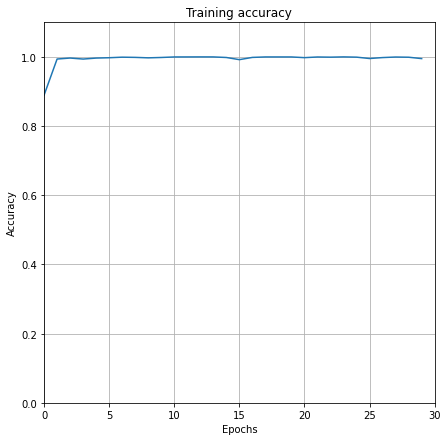




Test CNN 

y_test shape after applying one hot encoding : (14117, 9)

Time taken for predicting test set : 0:01:00.718589



Testing set CNN report

Number of classes predicted : 9

Confusion matrix : 



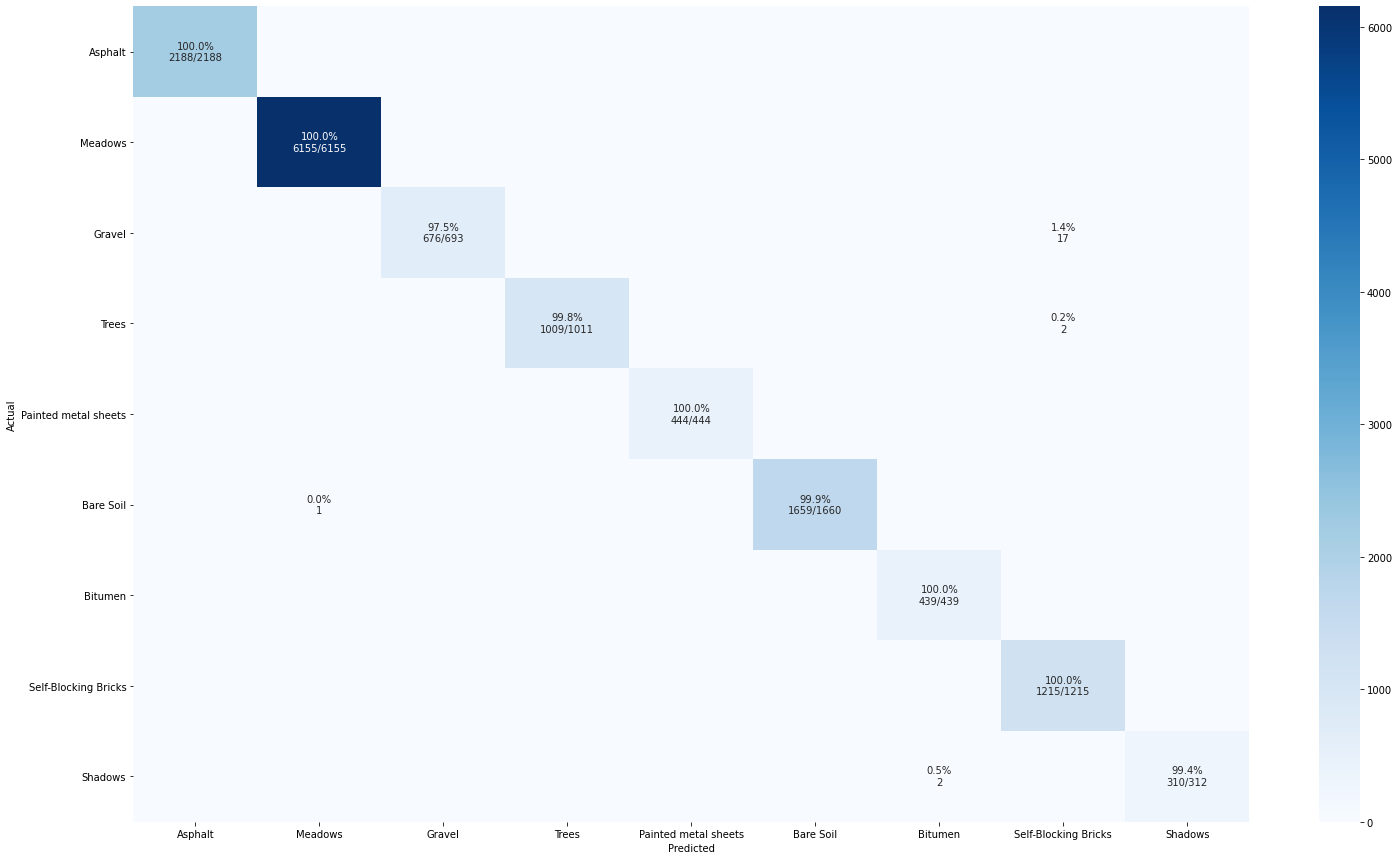


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      2188
             Meadows       1.00      1.00      1.00      6156
              Gravel       0.98      1.00      0.99       676
               Trees       1.00      1.00      1.00      1009
Painted metal sheets       1.00      1.00      1.00       444
           Bare Soil       1.00      1.00      1.00      1659
             Bitumen       1.00      1.00      1.00       441
Self-Blocking Bricks       1.00      0.98      0.99      1234
             Shadows       0.99      1.00      1.00       310

            accuracy                           1.00     14117
           macro avg       1.00      1.00      1.00     14117
        weighted avg       1.00      1.00      1.00     14117


Testing set accuracy : 99.84415952397818 %

Cohen kappa score : 0.997934778392646



Predicting entire image

Load dataset

X shape : (610, 340, 103)
y shape : (61


Time taken for predicting entire image : 0:37:17.268530





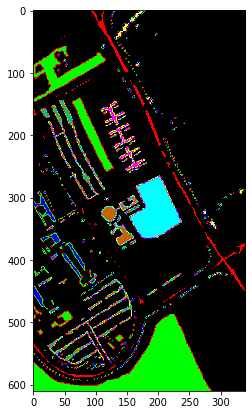

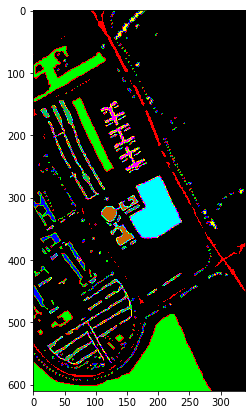




CNN report for predicting entire dataset

Number of classes predicted : 9

Confusion matrix : 



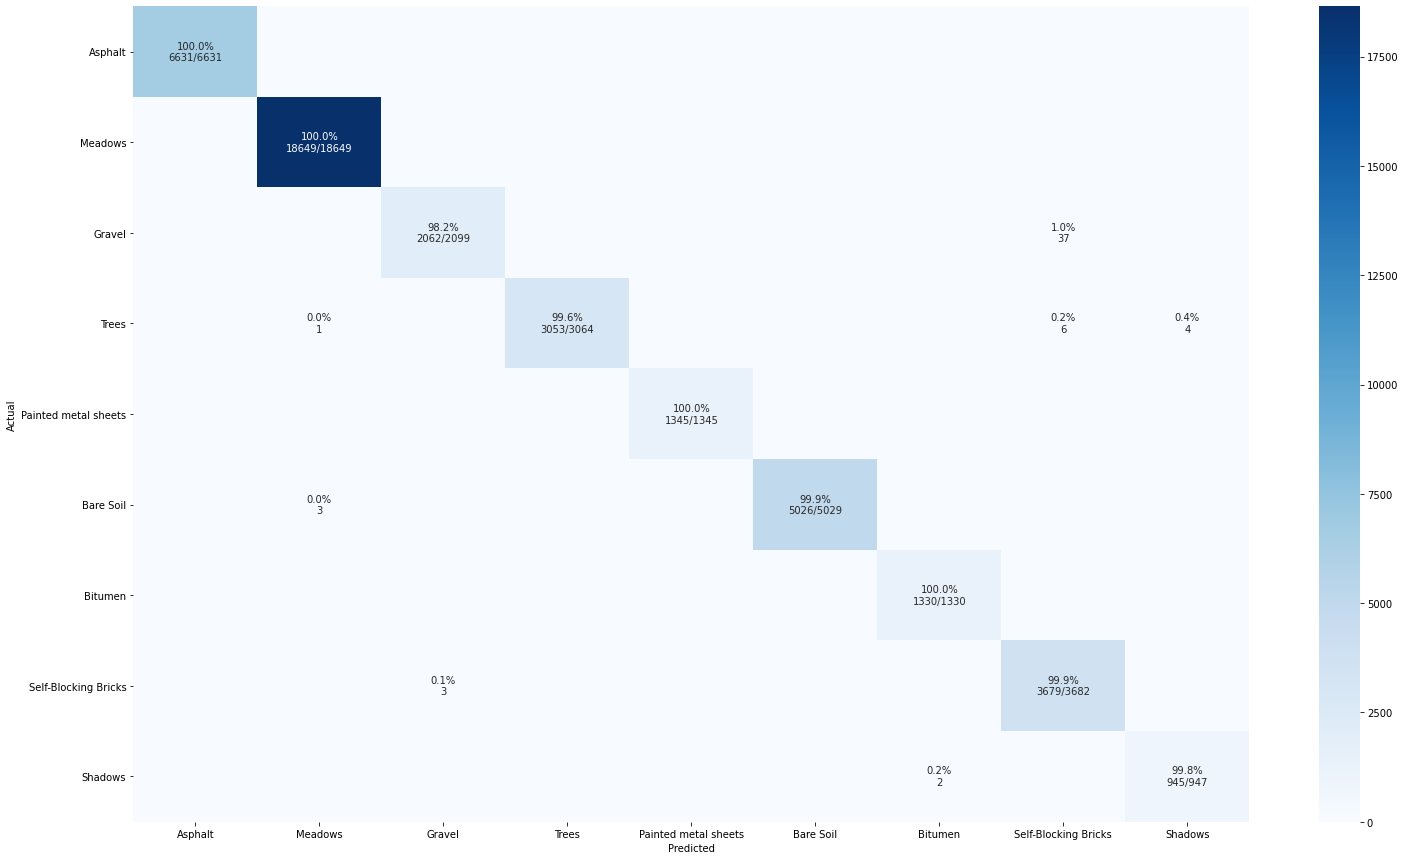


Classification report : 

                      precision    recall  f1-score   support

             Asphalt       1.00      1.00      1.00      6631
             Meadows       1.00      1.00      1.00     18653
              Gravel       0.98      1.00      0.99      2065
               Trees       1.00      1.00      1.00      3053
Painted metal sheets       1.00      1.00      1.00      1345
           Bare Soil       1.00      1.00      1.00      5026
             Bitumen       1.00      1.00      1.00      1332
Self-Blocking Bricks       1.00      0.99      0.99      3722
             Shadows       1.00      1.00      1.00       949

            accuracy                           1.00     42776
           macro avg       1.00      1.00      1.00     42776
        weighted avg       1.00      1.00      1.00     42776


Testing set accuracy : 99.869085468487 %

Cohen kappa score : 0.9982651780005509





In [ ]:
hybridSN(number_of_components = 20, window_size = 17, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

In [ ]:
hybridSN(number_of_components = 20, window_size = 19, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

In [ ]:
hybridSN(number_of_components = 20, window_size = 21, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

In [ ]:
hybridSN(number_of_components = 20, window_size = 23, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

In [ ]:
hybridSN(number_of_components = 20, window_size = 25, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)